In [16]:
!pip install -r requirements.txt
!pip install eep153_tools

import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
from eep153_tools.sheets import read_sheets

## Reading In Bukidnon Dataset

In [17]:
sheet = '1KjQu6ngxR_qxETh9Wx9f9ZmijMVkkevV'

InputFiles = {'Expenditures':(sheet,'Expenditures'),
               'Consumption':(sheet,'Quantities'),
               'HH Characteristics':(sheet,'HH Characteristics'),
               'FCT':(sheet,'FCT')}

quant = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='Quantities')
hh = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='HH Characteristics')
expend = pd.read_excel('Bukidnon 2003.xlsx',sheet_name ='Expenditures')
nut = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='FCT')

In [18]:
r = cfe.result.from_dataset('BUK.ds',engine='netcdf4')

# Energy                            16833.092949
# Protein                             377.781250
# Fiber, total dietary                235.663301
# Folate, DFE                        3269.930070
# Calcium, Ca                       10256.366550
# Carbohydrate, by difference        1179.924242
# Iron, Fe                            127.491987
# Magnesium, Mg                      2703.273237
# Niacin                              119.561407
# Phosphorus, P                      8294.908217
# Potassium, K                      41382.808858
# Riboflavin                            9.158257
# Thiamin                               9.062063
# Vitamin A, RAE                     6074.264277
# Vitamin B-12                         19.619580
# Vitamin B-6                          10.420531
# Vitamin C, total ascorbic acid      569.168124
# Vitamin E (alpha-tocopherol)        121.720862
# Vitamin K (phylloquinone)           706.475816
# Zinc, Zn

# Reference period, market
t,m = 2003, 'Bukidnon'

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(m=m)

p = r.prices.sel(m=m,drop=True)
p = p.to_dataframe('i').squeeze().dropna()
p = p.xs(2003.,level='variable')
p

#lwith this notebook we are looking at min of nutrients per household
#allows getting rid of different units for measuring and think ab ratio instead

i
Bagoong                          0.037190
Banana                           0.021401
Beef                             0.135031
Carrots                          0.027822
Chicken                          0.097764
Coffee                           0.732034
Cooking oil                      0.038578
Eggs                             0.092641
Food made from flour             0.016472
Fresh fish                       0.046502
Mangoes                          0.045497
Milk                             0.277523
Milo                             0.217887
Mongo and other products         0.038700
Onions                           0.043971
Peanut                           0.170558
Pork                             0.102934
Potato                           0.028599
Processed meat like longanisa    0.144143
Rice                             0.021202
Salt                             0.015549
Sardines                         0.078127
Sea weed                         0.035359
Soybean and other products      

## Grouping By Age/Sex and Matching to Recommended Dietary Allowances

In [19]:
zbar = r.z.sel(t=r.firstround,drop=True).mean(['j','m'])[:-1].squeeze() # Leave out log HSize

zbar = zbar.to_dataframe().squeeze()

In [20]:
rda = pd.read_csv('diet_minimums.csv').set_index('Nutrition').iloc[:,2:]

zbar['Boys'] = zbar['Males 5-10']*5/15 + zbar['Males 10-15']*5/15 + zbar['Males 15-20'] * 5/15
zbar['Girls'] = zbar['Females 5-10']*5/15 + zbar['Females 10-15']*5/15 + zbar ['Females 15-20'] * 5/15
zbar['Mothers'] = zbar['Females 15-20']*5/15 + zbar['Females 20-30']*10/15

rda['Boys'] = rda['M 4-8']*4/16 + rda['M 9-13']*5/16 + rda['M 14-18']*5/16 + rda['M 19-30']*2/16
rda['Girls'] = rda['F 4-8']*4/16 + rda['F 9-13']*5/16 + rda['F 14-18']*5/16 + rda['F 19-30']*2/16
rda['Mothers'] = rda['F 14-18']*4/16 + rda['F 19-30']*12/16

zbar = zbar[['Boys', 'Girls', 'Mothers']]
rda = rda[['Boys', 'Girls', 'Mothers']]
# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda.align(zbar,axis=1)
# This matrix product gives minimum nutrient requirements for average
# household in 1975
hh_rda = rda0.replace('',0)@zbar0
# RDA is /daily/, but  demands in BUK data are /weekly/:
hh_rda = hh_rda*7
hh_rda

Nutrition
Energy                            16833.092949
Protein                             377.781250
Fiber, total dietary                235.663301
Folate, DFE                        3269.930070
Calcium, Ca                       10256.366550
Carbohydrate, by difference        1179.924242
Iron, Fe                            127.491987
Magnesium, Mg                      2703.273237
Niacin                              119.561407
Phosphorus, P                      8294.908217
Potassium, K                      41382.808858
Riboflavin                            9.158257
Thiamin                               9.062063
Vitamin A, RAE                     6074.264277
Vitamin B-12                         19.619580
Vitamin B-6                          10.420531
Vitamin C, total ascorbic acid      569.168124
Vitamin E (alpha-tocopherol)        121.720862
Vitamin K (phylloquinone)           706.475816
Zinc, Zn                             74.027244
dtype: float64

In [21]:
UseNutrients=['calorie','protein','calcium','carbo','iron']

In [22]:
fct = nut.iloc[:,3:]
fct['i'] = fct['name']
fct = fct.set_index('i').iloc[:,1:]

# Select only desired nutrients from the fct table
fct = fct[UseNutrients]

# Rename and select desired nutrients from the hh_rda series
hh_rda = hh_rda[['Energy','Protein','Calcium, Ca','Carbohydrate, by difference','Iron, Fe']]
hh_rda = hh_rda.rename({'Energy':'calorie','Protein':'protein','Calcium, Ca':'calcium',
                        'Carbohydrate, by difference':'carbo','Iron, Fe':'iron'})

In [23]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

## Nutrient Demand

In [24]:
def nutrient_demand(x,p):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    c = r.demands(x,p)    


    fct0,c0 = fct.align(c,axis=0,join='inner')
    
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

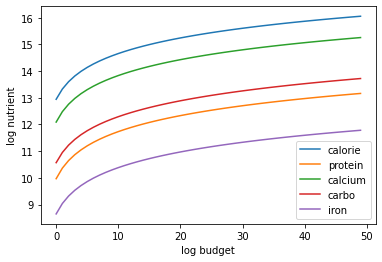

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)

df = pd.concat([np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X],axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0.5, 1.0, 'Sardines')

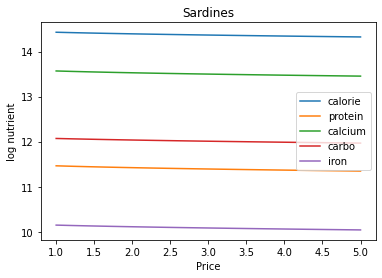

In [26]:
USE_GOOD = 'Sardines' # Also try Rice and Potato

# ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('Price')
ax.set_ylabel('log nutrient')
ax.set_title(USE_GOOD)

## Nutritional Adequacy

In [27]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

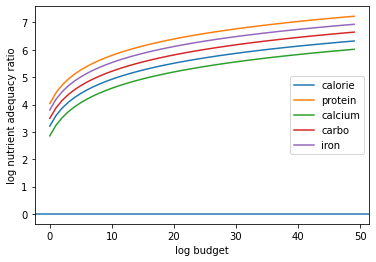

In [28]:
X = np.linspace(reference_x/5,reference_x*5,50)

ndf = pd.concat([np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X],axis=1).T

ax = ndf.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)

Text(0.5, 1.0, 'Sardines')

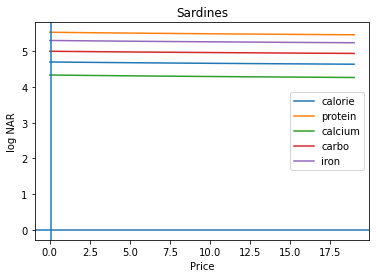

In [29]:
USE_GOOD = 'Sardines'

poorer_x = reference_x/2

Pscale = np.linspace(1,3,20).tolist()

log_nar = [np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] 
           for s0 in Pscale]

log_nar = pd.DataFrame(log_nar) 

ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


ax.axhline(0)
ax.axvline(p[USE_GOOD])
ax.set_title(USE_GOOD)

## Fixing Prices and Budgets

In [31]:
my_t = r.coords['t'].data.flatten()[0] # Period
my_m = r.coords['m'].data.flatten()[0] # Market
my_i = 'Sardines' # r.coords['i'].data.flatten()[0] # Good
#####################################################################

# p = r.prices.sel(u='Kilogram (kg)',t=my_t,m=my_m,drop=True)
p = r.prices.sel(m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze().loc[2003]

# ref_price = r.prices.sel(u='Kilogram (kg)',i=my_i,t=my_t,m=my_m)
ref_price = r.prices.sel(i=my_i,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

phat

i
Bagoong                          0.037190
Banana                           0.021401
Beef                             0.135031
Carrots                          0.027822
Chicken                          0.097764
Coffee                           0.732034
Cooking oil                      0.038578
Eggs                             0.092641
Food made from flour             0.016472
Fresh fish                       0.046502
Mangoes                          0.045497
Milk                             0.277523
Milo                             0.217887
Mongo and other products         0.038700
Onions                           0.043971
Peanut                           0.170558
Pork                             0.102934
Potato                           0.028599
Processed meat like longanisa    0.144143
Rice                             0.021202
Salt                             0.015549
Sardines                         0.078127
Sea weed                         0.035359
Soybean and other products      

In [34]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

### Marshallian vs. Hicksian Demand Curves

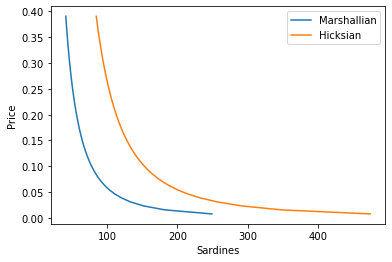

In [35]:
#my_i = 'bread'  # Interesting Ugandan staple

U0 = r.indirect_utility(x0,p)

#plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Marshallian")[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)

plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

### Welfare

In [36]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

### Price Changes, Revenue, and Compensating Variation

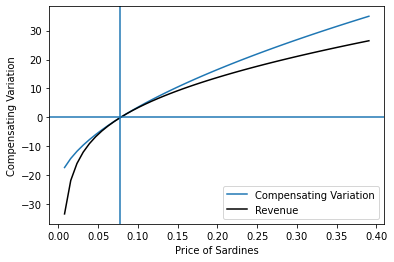

In [37]:
#effects of price changes on revenue (due to a tax or subsidy)
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

### Deadweight Loss

Text(0, 0.5, 'Deadweight Loss')

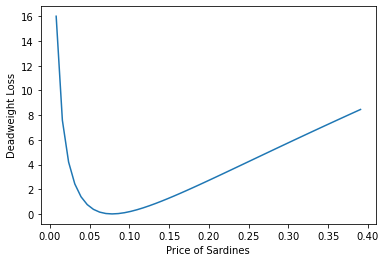

In [38]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")